In [286]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import json
import PyQt5
from scipy.interpolate import UnivariateSpline, CubicSpline
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
##### PARAMETERS #####
trackfile             = "./data/ims_track_midline.csv"  # Data in meters. Defined as midline and normal distance to track boundaries
parsed_trackfile_out  = "./data/ims_track_parsed.csv"   # Location to write parsed track data
vehicle_width         = 1.6                             # Meters
lateral_safety_buffer = 1.0                             # Min distance from vehicle outer edge to track bound for node creation (meters)

long_sep_straight     = 20                              # Longitudinal separation between nodes on straights (m)
long_sep_curve        = 8                               # Longitudinal separation between nodes on curves (m)
lat_sep               = 0.5                             # Lateral separation between nodes (m)
curvature_thresh      = 0.001                           # If segment's max curvature > threshold, segment is considered a curve, else a straight

cost_weights = {                                        # Weights for curvature cost function that sets costs on each segment length
    'w_len': 10,
    'w_kavg': 750,
    'w_kdelta': 1500,
    'w_offset': 5000
}

##### PARSE TRACK GEOMETRY #####

# Load track data and close the loop w/ start point
track_data = np.genfromtxt(trackfile, delimiter=",", names=True)
track_data = np.append(track_data, track_data[0])
# TODO if/else append or replace last point depending on distance from orginal last to start

# Fit midline spline using provided discretization
s_map        = np.linspace(0, 1.0, num=track_data.shape[0])
x_spline_mid = CubicSpline(s_map, track_data["x"])
y_spline_mid = CubicSpline(s_map, track_data["y"])

# Estimate length of track midline
# Should be close to 2.5 miles * 1609.34 = 4023.35 meters
n_interps    = 50000
t_fine       = np.linspace(0.0, 1.0, n_interps)
spl_coords   = np.zeros((n_interps, 2))
spl_coords[:,0] = x_spline_mid(t_fine)
spl_coords[:,1] = y_spline_mid(t_fine)
tracklength     = np.sum(np.sqrt(np.sum(np.power(np.diff(spl_coords, axis=0), 2), axis=1)))
print('Track Length: ', tracklength)

# Re-fit spline using estimated track length. Allows frenet station to correspond
# to actual distance along the raceline/midline 
s_map        = np.linspace(0, tracklength, num=track_data.shape[0])
x_spline_mid = CubicSpline(s_map, track_data["x"])
y_spline_mid = CubicSpline(s_map, track_data["y"])

# Remap to finer meter-level interpolation
s_fine = s_fine = np.arange(0, tracklength, 1)
x_mid  = x_spline_mid(s_fine)
y_mid  = y_spline_mid(s_fine)

# Get normal and tangent unit vectors wrt refline at every station
mid_norms    = get_unit_norms(s_fine, x_spline_mid, y_spline_mid)
mid_tangents = get_unit_tangents(s_fine, x_spline_mid, y_spline_mid)

# Headings and curvature
mid_headings = get_headings(s_fine, x_spline_mid, y_spline_mid)
mid_curvature = get_curvature(s_fine, x_spline_mid, y_spline_mid)

# Interpolate track widths
left_widths  = np.interp(s_fine, s_map, track_data["width_left"])
right_widths = np.interp(s_fine, s_map, track_data["width_right"])

# Get track boundary points (normal to midline)
left_boundary_xy  = frenet2cart(s_fine, -left_widths, x_spline_mid, y_spline_mid)
right_boundary_xy = frenet2cart(s_fine, right_widths, x_spline_mid, y_spline_mid)

# Get headings at track boundary by fitting boundary points to spline
left_bound_spline_x  = CubicSpline(s_fine, left_boundary_xy[:,0])
left_bound_spline_y  = CubicSpline(s_fine, left_boundary_xy[:,1])
right_bound_spline_x = CubicSpline(s_fine, right_boundary_xy[:,0])
right_bound_spline_y = CubicSpline(s_fine, right_boundary_xy[:,1])
left_bound_headings  = get_headings(s_fine, left_bound_spline_x, left_bound_spline_y)
right_bound_headings = get_headings(s_fine, right_bound_spline_x, right_bound_spline_y)

# Write parsed track data out to file
parsed_track = np.column_stack((s_fine, x_mid, y_mid, mid_headings, mid_curvature,
                                mid_norms, mid_tangents, 
                                left_widths, right_widths,
                                left_boundary_xy, left_bound_headings,
                                right_boundary_xy, right_bound_headings))
col_names = "s, x_mid, y_mid, psi_mid, kappa_mid x_n, y_n, x_t, y_t, \
             w_left, w_right, x_left, y_left, psi_left, x_right, y_right, psi_right"
np.savetxt(parsed_trackfile_out, parsed_track, delimiter=",", header=col_names)

Track Length:  4022.314734733444


In [251]:
##### GENERATE TRACK LATTICE #####

# Generate station intervals for nodes based on curvature parameters
stations = [0]                                       # start at s = 0
while s_fine[-1] - stations[-1] > long_sep_curve:
    s_cur = stations[-1]
    s_next_straight = s_cur + long_sep_straight
    s_next_curve = s_cur + long_sep_curve
    
    curved = False
    for s in range(s_cur, s_next_straight):
        if mid_curvature[s] >= curvature_thresh:
            curved = True
    if curved:
        stations.append(s_next_curve)
    else:
        stations.append(s_next_straight)



In [252]:
lat_disp = np.arange(-10,11,lat_sep)                 # possible lateral offsets (meters)
nodes = {}
for s in stations:
    nodes[str(s)] = {}

    for l in lat_disp:
        l_bound = -left_widths[s] + (vehicle_width/2 + lateral_safety_buffer)
        r_bound = right_widths[s] - (vehicle_width/2 + lateral_safety_buffer)
        if l_bound < l < r_bound:
            
            xy = frenet2cart(s, l, x_spline_mid, y_spline_mid)
            psi = np.interp(l, 
                            [-left_widths[s], 0, right_widths[s]], 
                            [left_bound_headings[s], mid_headings[s], right_bound_headings[s]]
                           )
            
            nodes[str(s)][str(l)] = {
                'x':     xy[0][0],
                'y':     xy[0][1],
                'psi':   psi
            }

In [284]:
# Edges dict

edges = {}
for i in range(len(stations) - 1):
    s_start = stations[i]
    s_end = stations[i+1]
    edges[str(s_start)] = {}
    
    for l_start, v_start in nodes[str(s_start)].items():
        edges[str(s_start)][str(l_start)] = {}
        x_start   = v_start['x']
        y_start   = v_start['y']
        psi_start = v_start['psi']
        
        for l_end, v_end in nodes[str(s_end)].items():
            x_end   = v_end['x']
            y_end   = v_end['y']
            psi_end = v_end['psi']
            
            x_a0 = x_start
            x_a1 = np.cos(psi_start)
            x_a2 = 3*x_end - np.cos(psi_end) - 2*x_a1 - 3*x_a0
            x_a3 = x_end - x_a2 - x_a1 - x_a0

            y_a0 = y_start
            y_a1 = np.sin(psi_start) 
            y_a2 = 3*y_end - np.sin(psi_end) - 2*y_a1 - 3*y_a0
            y_a3 = y_end - y_a2 - y_a1 - y_a0
            
            coeffs = ((x_a0, x_a1, x_a2, x_a3),
                      (y_a0, y_a1, y_a2, y_a3))
            
            ## Cost info
            cost = edge_cost_curv(coeffs, float(l_end), **cost_weights)
            
            edges[str(s_start)][str(l_start)][str(l_end)] = {
                'x_coef': coeffs[0],
                'y_coef': coeffs[1],
                'cost': cost
            }

    
    
    
    

In [260]:
%matplotlib qt
#### Plot Track ####
def plot_trackfile(track_data, left_boundary_xy, right_boundary_xy):
    x_tmp = np.array([x_i for i, x_i in enumerate(track_data["x"]) if i % 10 == 0])
    y_tmp = np.array([y_i for i, y_i in enumerate(track_data["y"]) if i % 10 == 0])
    plt.title('IMS Track (meters)')
    plt.plot(x_tmp, y_tmp, "o", x_mid, y_mid, "-")
    plt.plot(left_boundary_xy[:,0], left_boundary_xy[:,1], color="blue")
    plt.plot(right_boundary_xy[:,0], right_boundary_xy[:,1], color="purple")
    plt.axes().set_aspect('equal')
    plt.show()

plot_trackfile(track_data, left_boundary_xy, right_boundary_xy)

In [273]:
def plot_lattice_nodes():

    plt.figure(figsize=(10,16))
    plt.title('IMS Track Nodes')
    plt.plot(x_mid, y_mid, "-", color='orange')
    plt.plot(left_boundary_xy[:,0], left_boundary_xy[:,1], color="black")
    plt.plot(right_boundary_xy[:,0], right_boundary_xy[:,1], color="black")

    node_x = [nodes[s][l]['x'] for s in nodes for l in nodes[s]]
    node_y = [nodes[s][l]['y'] for s in nodes for l in nodes[s]]
    plt.plot(node_x, node_y, "o")
    
    plt.axes().set_aspect('equal')
    plt.show()
    
plot_lattice_nodes()    

In [293]:
def plot_lattice_paths_partial(x_mid, y_mid, left_boundary_xy, right_boundary_xy, 
                               nodes, edges, stations, s_start, s_end):
    s_part = [s for s in stations if s_start <= s <= s_end]

    plt.figure(figsize=(10,16))
    plt.title('IMS Track Nodes')
    plt.plot(x_mid, y_mid, "-", color='orange')
    plt.plot(left_boundary_xy[:,0], left_boundary_xy[:,1], color="black")
    plt.plot(right_boundary_xy[:,0], right_boundary_xy[:,1], color="black")

    node_x = [nodes[s][l]['x'] for s in nodes for l in nodes[s] if int(s) in s_part]
    node_y = [nodes[s][l]['y'] for s in nodes for l in nodes[s] if int(s) in s_part]
    plt.plot(node_x, node_y, "o", color="darkblue")

    u = np.linspace(0,1)
    coefs_x = [edges[s][ls][le]['x_coef'] for s in edges for ls in edges[s] for le in edges[s][ls] if int(s) in s_part[:-1]]
    coefs_y = [edges[s][ls][le]['y_coef'] for s in edges for ls in edges[s] for le in edges[s][ls] if int(s) in s_part[:-1]]
    edges_x = [spline_eval(u, *cx) for cx in coefs_x]
    edges_y = [spline_eval(u, *cy) for cy in coefs_y]
    for i in range(len(edges_x)):
        plt.plot(edges_x[i], edges_y[i], color="skyblue")

    plt.axes().set_aspect('equal')
    plt.show()

    
    
plot_lattice_paths_partial(x_mid, y_mid, left_boundary_xy, right_boundary_xy, 
                           nodes, edges, stations, 100, 220)

In [290]:
s_end

4020

In [291]:
s_start = 50
s_end = 140
s_part = [s for s in stations if s_start <= s <= s_end]
print(s_part)

coefs_x = [nodes[s][ls][le]['x_coef'] for s in nodes for ls in nodes[s] for le in nodes[s][ls] if int(s) in s_part[:-1]]

[60, 80, 100, 120, 140]


IndexError: invalid index to scalar variable.

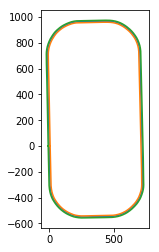

In [236]:
plt.plot(x_mid, y_mid)
plt.plot(left_boundary_xy[:,0], left_boundary_xy[:,1])
plt.plot(right_boundary_xy[:,0], right_boundary_xy[:,1])

plt.axes().set_aspect('equal')